# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants are employed
4. Applicants with higher education level
5. Properties in urban areas with high growth perspectives
6. Applicants  that have appropiate income for the loan amount (important for paying back)

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

In [3]:
#import libraries
import pandas as pd
import numpy as np

#libraries for stats
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

#libraries for plots
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics.cluster import contingency_matrix

#Misc
import copy 
import warnings
warnings.filterwarnings('ignore')

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [4]:
#load dataframe
df = pd.read_csv("data.csv") 

#Print shape and view
print(df.shape)
df.head()

(614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
#change Applicantincome to float
df['ApplicantIncome'] = pd.to_numeric(df['ApplicantIncome'], 
                                      downcast = "float")

#check types
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float32
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [6]:
#check for missing values - percentage
df.isnull().sum()/len(df)*100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

Gender, Married, Dependents, Self_employed, Loan Amount, Loan Amount Term and credit history have null values

In [7]:
#Look at basic stats for numerical variables
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459473,1621.245798,146.412162,342.00000,0.842199
std,6109.041504,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Yes, missing values in Loan Amount, Loan Amount Term and Credit History.

Applicant income and co applicant income have wider standard deviations due to low min values and high max values.

Outliers in Loan Amount and Loan Amount term.

1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.

In [8]:
#number of applicants that have credit history
df.Credit_History.value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

475 applicants have a credit history, 89 do not. This column also has 50 missing values however.

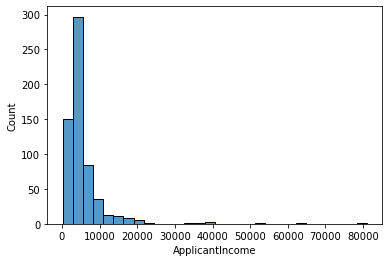

In [9]:
#Check distribution of Applicant income
sns.histplot(data=df, x = df.ApplicantIncome, bins =30)

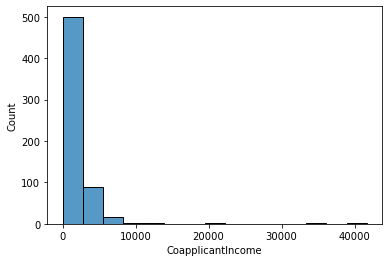

In [10]:
#Check distribution of Applicant income
sns.histplot(data=df, x = df.CoapplicantIncome, bins =15)

The distribution of Applicant income makes sense, majority of people will make around the median, and you will have outliers of people who make way more than the average person.

When we compare the mean and median (50% percentile), we can see that the mean is skewed due to the higher percentiles in both the Applicant and Coapplicant Incomes, however this is more seen in the Applicant income.

    Applicant mean is 5403.5 and the median is 3812.5
    Coapplicant mean is 1621.2 and the median is 1188.5

We can also see a higher standard deviation in the Applicant income.

With the box plots we can see the outliers more clearly

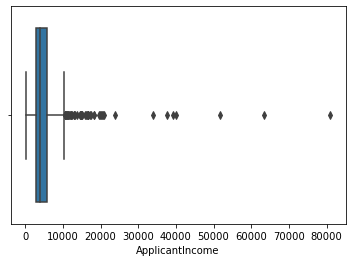

In [11]:
#boxplot of applicant income
sns.boxplot(x=df.ApplicantIncome)

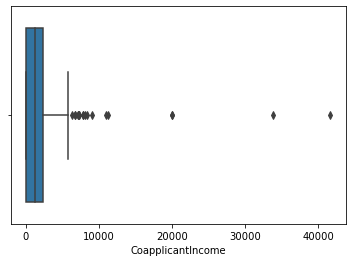

In [12]:
#boxplot of Coapplicant income
sns.boxplot(x=df.CoapplicantIncome)

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [13]:
cat_col = df[['Dependents','Gender', 'Married', 'Education', 'Self_Employed', 
              'Credit_History', 'Property_Area', 'Loan_Status']]

for col in cat_col:
    print(cat_col[col].value_counts())

0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64
Male      489
Female    112
Name: Gender, dtype: int64
Yes    398
No     213
Name: Married, dtype: int64
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
No     500
Yes     82
Name: Self_Employed, dtype: int64
1.0    475
0.0     89
Name: Credit_History, dtype: int64
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64
Y    422
N    192
Name: Loan_Status, dtype: int64


Based on the value counts we can notice some trends:

    First, we can see that the majority of applicants have no dependents.
    Second, the majority of applicants are Male. (missing values)
    Third, applicants on average tend to be married. (missing values)
    Fourth, the majority of applicants are graduates
    Fifth, not many applicants are self-employed. (missing values)
    Sixth, the majority of applicants have credit history. (missing values)
    Seventh, there is a relatively even distribution between the 3 property types. However the majority of applicants live in a semi-urban or urban setting.
    Lastly, The majority of applicants have an approved loan status (target variable)

Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

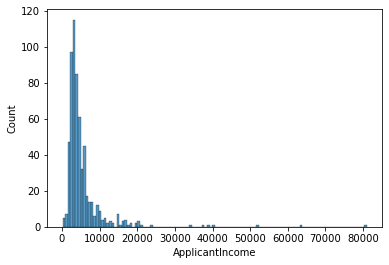

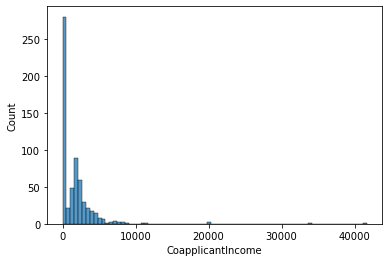

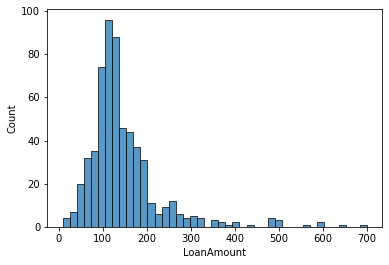

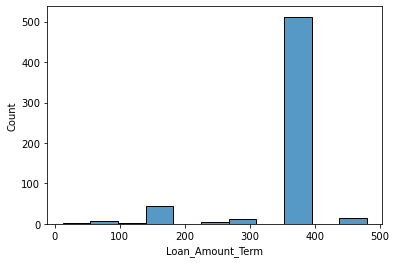

In [14]:
num_col = df[['ApplicantIncome', 'CoapplicantIncome', 
              'LoanAmount', 'Loan_Amount_Term']]

for col in num_col:
    plt.figure()
    sns.histplot(data = num_col, x = num_col[col])

In [15]:
#check values for Loan Amount Term
df.Loan_Amount_Term.value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

We can see a few trends when looking at the numerical columns:

    First, we have already looked at the skewness of both the Applicant and CoApplicant Incomes
    Second, we can see that the majority of loans is also skewed to "lower" amounts. Majority of loan amounts for applicants is 128 000, however because of the skewness, it mean is 146 400
    Third, we can see that the majority of applicants have a long amount terms. The majority have 360 months or 30 years.

### Data Analysis

Study distribution using scatterplots on numerical features

In [16]:
#create ordinal dataframe for data analysis
df_ordinal = copy.deepcopy(df)

df_ordinal = df_ordinal.drop('Loan_ID', axis =1)

df_ordinal = df_ordinal.replace({"Gender": {"Male" :0, "Female": 1},
                                "Married" : {"No" : 0, "Yes": 1},
                                "Education" : {"Not Graduate": 0, "Graduate":1},
                                "Self_Employed" : {"No":0, "Yes":1},
                                 "Property_Area": {"Rural":0, "Semiurban":1,
                                                  "Urban":2},
                                 "Dependents" : {"3+": 3},
                                 "Loan_Status": {"N":0, "Y":1}})

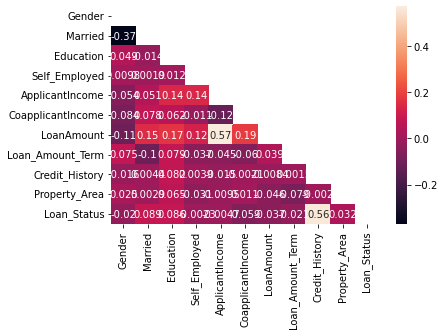

In [17]:
#Apply correlation
matrix_corr = df_ordinal.corr()

#Create plot, applying mask (cut in half)
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))
sns.heatmap(matrix_corr, annot=True, mask = mask)

In this correlation plot we can see that Loan Amount x Applicant income, Loan_Status and Credit_History are highly correlated.  Loan Amount and Applicant income seem to be major factors

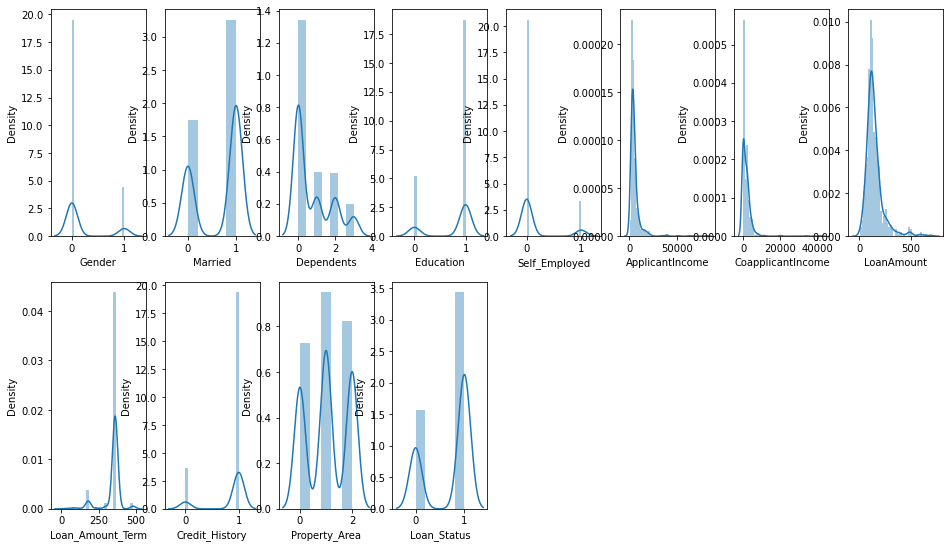

In [18]:
#Check distribution skewness

#exctract column values, identify number of columns and rows
l = df_ordinal.columns.values 
number_of_columns=8
number_of_rows = len(l)-1/number_of_columns

#plot figure for each column
plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df_ordinal[l[i]],kde=True) 

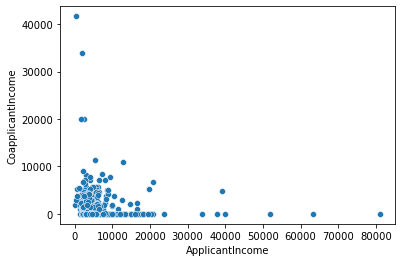

In [19]:
#looking at applicant income vs coapplicant income
sns.scatterplot(data=df, x='ApplicantIncome', y='CoapplicantIncome')

In [20]:
#Let us check correlation
#create new variable
income = df[['ApplicantIncome', 'CoapplicantIncome']]

#check Pearson correlation
print(income.corr())

                   ApplicantIncome  CoapplicantIncome
ApplicantIncome           1.000000          -0.116605
CoapplicantIncome        -0.116605           1.000000


There is no correlation between the applicant income and the coapplicant income

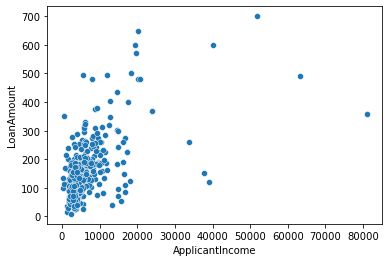

In [21]:
#looking at applicant income and loan amount
sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount')

In [22]:
#Lets check the correlation
loan_income = df[['ApplicantIncome', 'LoanAmount']]

#check Pearson correlation
print(loan_income.corr())

                 ApplicantIncome  LoanAmount
ApplicantIncome         1.000000    0.570909
LoanAmount              0.570909    1.000000


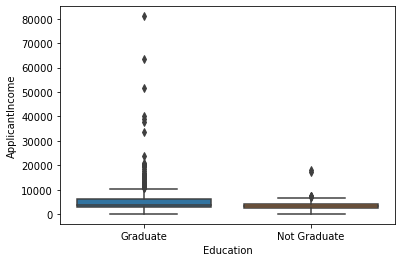

In [23]:
#Look at distribution of income segregated by Education
sns.boxplot(data=df, x = 'Education', y='ApplicantIncome')

In [24]:
#TTest to check significance between education and applicant income
stats.ttest_rel(df_ordinal['Education'], df_ordinal['ApplicantIncome'])

Ttest_relResult(statistic=-21.91413232071648, pvalue=4.7578786268974535e-79)

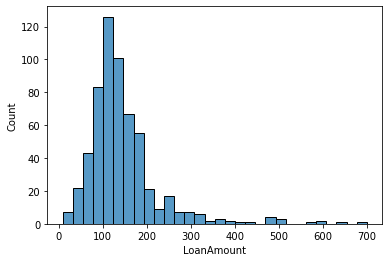

In [25]:
#Histogram for loan amount
sns.histplot(data = df, x = 'LoanAmount', bins = 30)

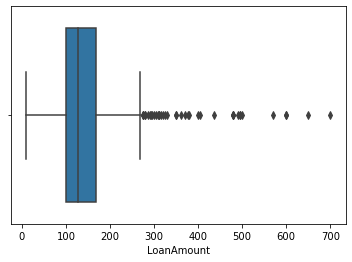

In [26]:
#box plot for loan amount
sns.boxplot(data=df, x = 'LoanAmount')

There might be some extreme values. Both `ApplicantIncome` and `LoanAmount` require some amount of data munging. `LoanAmount` has missing and well as extreme values values, while `ApplicantIncome` has a few extreme values, which demand deeper understanding. 

Try to understand categorical variables in more details using `pandas.DataFrame.pivot_table` and some visualizations.

In [27]:
#Looking at loan status via the median applicant income & grouped by education and self_employed
pd.pivot_table(df, values = 'ApplicantIncome', index = ['Education', 'Self_Employed'],
                      columns = ['Loan_Status'], aggfunc=np.median)

Loan_Status                      N       Y
Education    Self_Employed                
Graduate     No             4000.0  3852.0
             Yes            6050.0  6325.0
Not Graduate No             3042.0  3357.0
             Yes            4053.0  5751.5

In [28]:
#perform three-way ANOVA
model = ols("ApplicantIncome ~ C(Education, Sum) + C(Self_Employed, Sum) + C(Loan_Status, Sum) + C(Education, Sum)*C(Self_Employed, Sum)*C(Loan_Status, Sum)", data=df_ordinal).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,5.441703e+09,1.0,169.881639,3.361813e-34
"C(Education, Sum)",1.703694e+08,1.0,5.318672,2.145344e-02
"C(Self_Employed, Sum)",1.782243e+08,1.0,5.563891,1.866876e-02
"C(Loan_Status, Sum)",3.563445e+07,1.0,1.112453,2.919931e-01
"C(Education, Sum):C(Self_Employed, Sum)",2.760904e+06,1.0,0.086191,7.691824e-01
"C(Education, Sum):C(Loan_Status, Sum)",2.119673e+07,1.0,0.661729,4.162873e-01
"C(Self_Employed, Sum):C(Loan_Status, Sum)",8.289768e+07,1.0,2.587939,1.082302e-01
"C(Education, Sum):C(Self_Employed, Sum):C(Loan_Status, Sum)",3.308109e+06,1.0,0.103274,7.480524e-01
Residual,1.838655e+10,574.0,NaN,NaN


Here we can see that people who are both graduates and self-employed have more loans compared to those you have graduated and are not self employed. However this is also the same trend in the denied loans.

People who are non-graduates seem and not self-employed are the least likely to get an approved loan.

The three way anova Shows significance across all relationships. So both education and self employment have a significant relationship with Loan Status

In [29]:
#Looking at loan status via the median applicant income & grouped by property type & credit history
pd.pivot_table(df, values = 'ApplicantIncome', index = ['Property_Area', 'Credit_History'],
                      columns = ['Loan_Status'], aggfunc=np.median)

Loan_Status                        N       Y
Property_Area Credit_History                
Rural         0.0             3595.0  3700.0
              1.0             4583.0  3846.0
Semiurban     0.0             3128.0  5104.0
              1.0             4680.0  3854.0
Urban         0.0             3173.0  4333.0
              1.0             3600.0  3583.5

In [30]:
#perform three-way ANOVA checking age group and type against income
model = ols("ApplicantIncome ~ C(Property_Area, Sum) + C(Credit_History, Sum) + C(Loan_Status, Sum) + C(Property_Area, Sum)*C(Credit_History, Sum)*C(Loan_Status, Sum)", data=df_ordinal).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,2.514918e+09,1.0,64.304272,6.408852e-15
"C(Property_Area, Sum)",8.840889e+07,2.0,1.130269,3.236925e-01
"C(Credit_History, Sum)",8.409049e+06,1.0,0.215012,6.430498e-01
"C(Loan_Status, Sum)",7.747144e+06,1.0,0.198088,6.564433e-01
"C(Property_Area, Sum):C(Credit_History, Sum)",4.705805e+07,2.0,0.601617,5.482840e-01
"C(Property_Area, Sum):C(Loan_Status, Sum)",1.738572e+08,2.0,2.222689,1.092860e-01
"C(Credit_History, Sum):C(Loan_Status, Sum)",1.729611e+07,1.0,0.442246,5.063180e-01
"C(Property_Area, Sum):C(Credit_History, Sum):C(Loan_Status, Sum)",2.304537e+08,2.0,2.946250,5.336310e-02
Residual,2.158853e+10,552.0,NaN,NaN


Here we can see that the type of property does not have a huge impact on the loan status.

As for credit history, we can see that people who don't have credit history get more loans than those with credit history. This shows that this data is not a great predictor. Perhaps having a column on credit score as well, would have helped. 

And when you view both together, you can still see this trend.

Again with the 3-way anova we can see that both Property Area and Credit History have a significant relationship with Loan Status, as well as all together

In [31]:
#Looking at loan status via the median applicant income & grouped by married & dependents
pd.pivot_table(df, values = 'LoanAmount', index = ['Married', 'Dependents'],
                      columns = ['Loan_Status'], aggfunc=np.median)

Loan_Status             N      Y
Married Dependents              
No      0           112.5  119.0
        1           133.0  112.0
        2           110.0  136.0
        3+          335.0  220.0
Yes     0           135.0  128.0
        1           151.0  140.0
        2           133.0  133.0
        3+          139.0  128.0

In [32]:
#perform three-way ANOVA checking age group and type against income
model = ols("ApplicantIncome ~ C(Married, Sum) + C(Dependents, Sum) + C(Loan_Status, Sum) + C(Married, Sum)*C(Dependents, Sum)*C(Loan_Status, Sum)", data=df_ordinal).fit()
sm.stats.anova_lm(model, typ=3)

,sum_sq,df,F,PR(>F)
Intercept,5.308173e+09,1.0,141.396070,2.399025e-29
"C(Married, Sum)",4.263746e+07,1.0,1.135752,2.869928e-01
"C(Dependents, Sum)",2.100042e+08,3.0,1.864657,1.343909e-01
"C(Loan_Status, Sum)",1.403476e+07,1.0,0.373850,5.411515e-01
"C(Married, Sum):C(Dependents, Sum)",6.016736e+07,3.0,0.534235,6.589645e-01
"C(Married, Sum):C(Loan_Status, Sum)",2.025241e+07,1.0,0.539472,4.629468e-01
"C(Dependents, Sum):C(Loan_Status, Sum)",2.463537e+07,3.0,0.218741,8.834043e-01
"C(Married, Sum):C(Dependents, Sum):C(Loan_Status, Sum)",1.113630e+08,3.0,0.988808,3.976091e-01
Residual,2.188650e+10,583.0,NaN,NaN


Here we can see another trend:

Those that aren't married tend to be approved for higher loan amounts if they have more dependents.
Those that are married get higher loan amounts than those not married, however the median loan amount does not depend as much on the number of dependents.

Again Here we see a significant relationship with Married and Dependents together and serparetly against Loan Status. Therefore they are also predictors

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

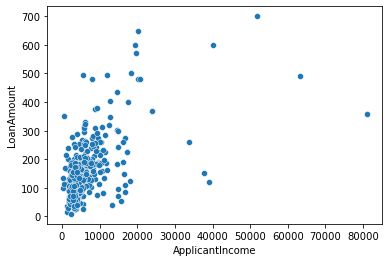

In [33]:
#Check Applicant income vs Loan Amount
sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount')

(606, 13)


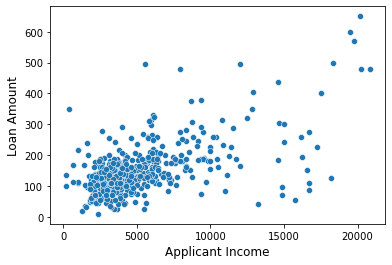

In [34]:
#drop outliers
df = df.drop(df[(df['ApplicantIncome']>23000) & (df['LoanAmount']>0)].index)
print(df.shape)
plt = sns.scatterplot(data=df, x='ApplicantIncome', y='LoanAmount')
plt.set_xlabel('Applicant Income', fontsize = 12)
plt.set_ylabel('Loan Amount', fontsize = 12)

fig = plt.get_figure()
fig.savefig('laonvsincome.png')

In [35]:
#Lets check the correlation
loan_income = df[['ApplicantIncome', 'LoanAmount']]

#check Pearson correlation
print(loan_income.corr())

                 ApplicantIncome  LoanAmount
ApplicantIncome         1.000000    0.607595
LoanAmount              0.607595    1.000000


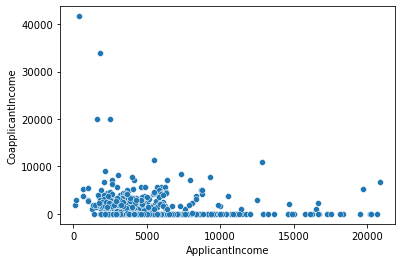

In [36]:
#Check outliers with Applicant income and Coapplicant
sns.scatterplot(data=df, x='ApplicantIncome', y='CoapplicantIncome')

(602, 13)


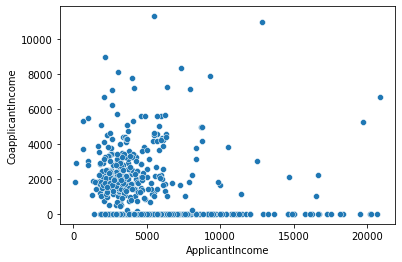

In [37]:
#drop outliers
df = df.drop(df[(df['ApplicantIncome']>0) & (df['CoapplicantIncome']>18000)].index)
print(df.shape)
sns.scatterplot(data=df, x='ApplicantIncome', y='CoapplicantIncome')

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

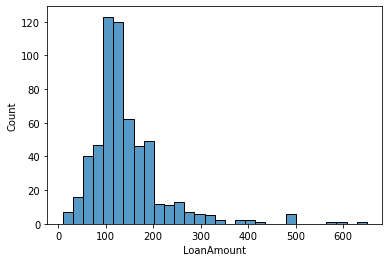

In [38]:
#Histplot for loan amount
sns.histplot(data = df, x = 'LoanAmount', bins = 30)

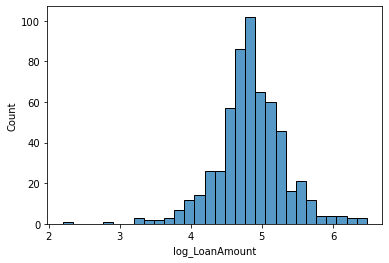

In [39]:
#apply log
df['log_LoanAmount'] = np.log(df['LoanAmount'])
sns.histplot(data = df, x = 'log_LoanAmount', bins = 30)

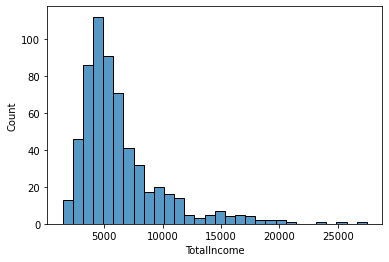

In [40]:
#Hist plot of total income

#first create total income
df['TotalIncome'] = df.ApplicantIncome + df.CoapplicantIncome

#plot
sns.histplot(data = df, x = 'TotalIncome', bins = 30)

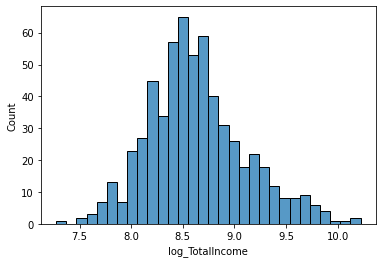

In [41]:
#take log of total income
df['log_TotalIncome'] = np.log(df['TotalIncome'])
sns.histplot(data = df, x = 'log_TotalIncome', bins = 30)

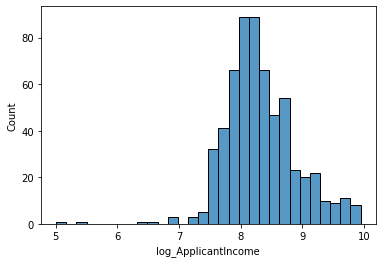

In [42]:
#Log transform of applicant income
df['log_ApplicantIncome'] = np.log(df['ApplicantIncome'])
sns.histplot(data = df, x = 'log_ApplicantIncome', bins = 30)

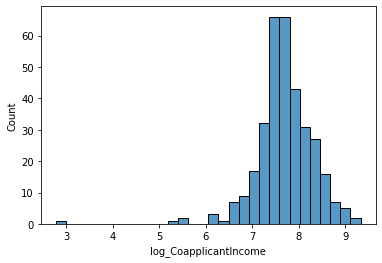

In [43]:
#Log transformation of Coapplicant income
df['log_CoapplicantIncome'] = np.log(df['CoapplicantIncome'])
sns.histplot(data = df, x = 'log_CoapplicantIncome', bins = 30)

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.

Impute missing values for all columns. Use the values which you find most meaningful (mean, mode, median, zero.... maybe different mean values for different groups)

    I will do this during the preprocessing for the pipeline

## Create a Predictive Model

### Model 1

In [44]:
#create deep copy
data = copy.deepcopy(df)
data.head(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,log_LoanAmount,TotalIncome,log_TotalIncome,log_ApplicantIncome,log_CoapplicantIncome
0,LP001002,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,1.0,Urban,Y,NaN,5849.0,8.674026,8.674026,-inf


In [45]:
#drop unnesscessary columns
data = data.drop(['Loan_ID','Credit_History','log_LoanAmount','log_TotalIncome',
                   'log_ApplicantIncome', 'log_CoapplicantIncome'], axis=1)
data.head(1)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,Loan_Status,TotalIncome
0,Male,No,0,Graduate,No,5849.0,0.0,NaN,360.0,Urban,Y,5849.0


In [46]:
#first replace loan_status values into ordinals
data['Loan_Status'] = data['Loan_Status'].replace(to_replace=['Y','N'], value=[1,0])

#split into X and y (target)
X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [47]:
X_train.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Property_Area', 'TotalIncome'],
      dtype='object')

In [48]:
def object_to_num(df):
    df['Dependents'] = df['Dependents'].replace('3+', float(3))
    df = df.astype({'Dependents': 'float32'})
    return df

P = object_to_num(X_train)
P

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,TotalIncome
9,Male,Yes,1.0,Graduate,No,12841.0,10968.0,349.0,360.0,Semiurban,23809.0
381,Male,No,0.0,Graduate,No,5941.0,4232.0,296.0,360.0,Semiurban,10173.0
534,Female,No,0.0,Not Graduate,Yes,18165.0,0.0,125.0,360.0,Urban,18165.0
193,Male,No,0.0,Graduate,No,3858.0,0.0,76.0,360.0,Semiurban,3858.0
132,Male,No,0.0,Graduate,No,2718.0,0.0,70.0,360.0,Semiurban,2718.0
...,...,...,...,...,...,...,...,...,...,...,...
71,Male,Yes,2.0,Not Graduate,Yes,1875.0,1875.0,97.0,360.0,Semiurban,3750.0
106,Male,Yes,2.0,Graduate,No,11417.0,1126.0,225.0,360.0,Urban,12543.0
275,Male,Yes,1.0,Graduate,No,2750.0,1842.0,115.0,360.0,Semiurban,4592.0
445,Male,Yes,1.0,Graduate,Yes,3466.0,1210.0,130.0,360.0,Rural,4676.0


In [49]:
def to_dataframe(x):
    columns = ['Dependents','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Loan_Amount_Term',
              'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    return pd.DataFrame(x, columns=columns)

Q = to_dataframe(P)
Q

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,TotalIncome,Loan_Amount_Term,Gender,Married,Education,Self_Employed,Property_Area
9,1.0,12841.0,10968.0,349.0,23809.0,360.0,Male,Yes,Graduate,No,Semiurban
381,0.0,5941.0,4232.0,296.0,10173.0,360.0,Male,No,Graduate,No,Semiurban
534,0.0,18165.0,0.0,125.0,18165.0,360.0,Female,No,Not Graduate,Yes,Urban
193,0.0,3858.0,0.0,76.0,3858.0,360.0,Male,No,Graduate,No,Semiurban
132,0.0,2718.0,0.0,70.0,2718.0,360.0,Male,No,Graduate,No,Semiurban
...,...,...,...,...,...,...,...,...,...,...,...
71,2.0,1875.0,1875.0,97.0,3750.0,360.0,Male,Yes,Not Graduate,Yes,Semiurban
106,2.0,11417.0,1126.0,225.0,12543.0,360.0,Male,Yes,Graduate,No,Urban
275,1.0,2750.0,1842.0,115.0,4592.0,360.0,Male,Yes,Graduate,No,Semiurban
445,1.0,3466.0,1210.0,130.0,4676.0,360.0,Male,Yes,Graduate,Yes,Rural


In [50]:
def to_log(df):
    columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome']
    for x in columns:
        df[x] = df[x].apply(lambda x: np.log(x))
    df = df.drop(columns, axis=1)
    return df

R = to_log(Q)
R

,Dependents,Loan_Amount_Term,Gender,Married,Education,Self_Employed,Property_Area
9,1.0,360.0,Male,Yes,Graduate,No,Semiurban
381,0.0,360.0,Male,No,Graduate,No,Semiurban
534,0.0,360.0,Female,No,Not Graduate,Yes,Urban
193,0.0,360.0,Male,No,Graduate,No,Semiurban
132,0.0,360.0,Male,No,Graduate,No,Semiurban
...,...,...,...,...,...,...,...
71,2.0,360.0,Male,Yes,Not Graduate,Yes,Semiurban
106,2.0,360.0,Male,Yes,Graduate,No,Urban
275,1.0,360.0,Male,Yes,Graduate,No,Semiurban
445,1.0,360.0,Male,Yes,Graduate,Yes,Rural


In [51]:
X_test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Property_Area,TotalIncome
110,Male,No,0,Graduate,No,5316.0,0.000000,136.0,360.0,Urban,5316.000000
428,Male,Yes,0,Graduate,No,2920.0,16.120001,87.0,360.0,Rural,2936.120001
577,Male,No,0,Graduate,No,3229.0,2739.000000,110.0,360.0,Urban,5968.000000
77,Male,Yes,1,Graduate,Yes,1000.0,3022.000000,110.0,360.0,Urban,4022.000000
186,Male,Yes,1,Graduate,Yes,2178.0,0.000000,66.0,300.0,Rural,2178.000000


In [52]:
#FUNCTIONS AND CLASS OBJECT

def object_to_num_2(df):
    """
    This function Takes in the dependents column and turns the 3+ into a float
    """
    df['Dependents'] = df['Dependents'].replace('3+', float(3))
    df = df.astype({'Dependents': 'float32'})
    return df

def to_dataframe_2(x):
    """
    This function takes in a dataframe and applies the column names
    """
    columns = ['Dependents','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Loan_Amount_Term',
              'Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
    return pd.DataFrame(x, columns=columns)

def to_log_2(df):
    """
    This function applies the log function to the columns you want to apply it to and returns the dataframe
    """
    columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome']
    for x in columns:
        df[x] = df[x].apply(lambda x: np.log(x))
    df = df.drop(columns, axis=1)
    return df

class objectTransformer:
    
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **fit_params):
        return self.func(X)

In [53]:
#define numerical and categorical features
num_col = ['Dependents','ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'TotalIncome', 'Loan_Amount_Term']
cat_col = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']

#create column transformer
Fill_NA = ColumnTransformer([('fill_median', SimpleImputer(strategy='mean'), num_col), 
                            ('most_freq', SimpleImputer(strategy='most_frequent'), cat_col)],
                           remainder = 'passthrough')

#create preprocessing pipeline
preprocessing = Pipeline([('dep_change', objectTransformer(object_to_num_2)),
                          ('fill_na', Fill_NA),
                          ('to_df', objectTransformer(to_dataframe_2)),
                         ('to_log', objectTransformer(to_log_2))])


#create feature union
#feature_union = FeatureUnion([("pca", PCA(n_components=3)),
#                             ('kbest', SelectKBest(k=3))])

#create pipeline
Pipeline_rfc = Pipeline([('preprocessing', preprocessing),
                         ('one_hot', OneHotEncoder(sparse=False)),
                         ('scaling', MinMaxScaler()),
                        ('model', RandomForestClassifier(random_state=42))])

#fit
Pipeline_rfc.fit(X_train, y_train)

#find accruacy
y_pred = Pipeline_rfc.predict(X_test)

# Calculate Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

ValueError: Found unknown categories [36.0] in column 1 during transform

In [ ]:
#apply grid search to hypertune

param_grid = {'model' : [RandomForestClassifier(random_state=42),
                        GradientBoostingClassifier(random_state=42)],
              'model__n_estimators': [10,100,200,300], 
              'model__max_depth': [2, 5, None],
              'model__min_samples_split': [2,10,30]}

# create a Grid Search object
grid_search = GridSearchCV(Pipeline_rfc, param_grid, verbose=10, refit=True)    

# fit the model and tune parameters
grid_search.fit(X_train, y_train)

In [ ]:
#print best params and score
print('Best Params', grid_search.best_params_)
print('Final score is: ', grid_search.score(X_test, y_test))

#Find MSE
prediction = grid_search.predict(X_train)
print( "Mean Squared Error:", mean_squared_error(y_train, prediction))

### Model 2

In [ ]:
#create deepcopy
test = copy.deepcopy(df)

#drop unnesscessary columns
test = test.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome', 'Property_Area',
                  'log_LoanAmount','log_TotalIncome', 'Education',
                   'log_ApplicantIncome', 'log_CoapplicantIncome'], axis=1)
test.head(1)

,Gender,Married,Dependents,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,TotalIncome
0,Male,No,0,No,NaN,360.0,1.0,Y,5849.0


In [ ]:
#first replace loan_status values into ordinals
test['Loan_Status'] = test['Loan_Status'].replace(to_replace=['Y','N'], value=[1,0])

#split into X and y (target)
X2 = test.drop('Loan_Status', axis=1)
y2 = test['Loan_Status']

#train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.2, random_state=23)

In [ ]:
#FUNCTIONS AND CLASS OBJECT

def object_to_num(df):
    """
    This function Takes in the dependents column and turns the 3+ into a float
    """
    df['Dependents'] = df['Dependents'].replace('3+', float(3))
    df = df.astype({'Dependents': 'float64'})
    return df

def to_dataframe(x):
    """
    This function takes in a dataframe and applies the column names
    """
    columns = ['Gender', 'Married', 'Dependents','Self_Employed',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'TotalIncome']
    return pd.DataFrame(x, columns=columns)

def to_log(df):
    """
    This function applies the log function to the columns you want to apply it to and returns the dataframe
    """
    columns = ['LoanAmount', 'TotalIncome']
    for x in columns:
        df[x] = df[x].apply(lambda x: np.log(x))
    df = df.drop(columns, axis=1)
    return df

class objectTransformer:
    """
    Class object transformer, takes in function to apply in preprocessing step of Pipeline
    """
    def __init__(self, func):
        self.func = func
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **fit_params):
        return self.func(X)

In [ ]:
#create column transformer
fillna_trans = ColumnTransformer([
     ('fillna_mode', SimpleImputer(strategy="most_frequent"), ['Gender','Dependents']),
     ('fillna_No', SimpleImputer(strategy='constant', fill_value='No'), ['Married', 'Self_Employed']),
     ('fillna_mean', SimpleImputer(strategy='mean'), ['LoanAmount','Loan_Amount_Term']),
     ('fillna_zero', SimpleImputer(strategy='constant',fill_value=0), ['Credit_History'])],
     remainder='passthrough')

#create preprocessing pipeline
preprocessing = Pipeline([('dep_change', objectTransformer(object_to_num)),
                          ('fill_na', fillna_trans),
                          ('to_df', objectTransformer(to_dataframe)),
                         ('to_log', objectTransformer(to_log))])

#create feature union
#feature_union = FeatureUnion([("pca", PCA(n_components=3)),
#                             ('kbest', SelectKBest(k=3))])

#create pipeline
Pipeline_rfc2 = Pipeline([('preprocessing', preprocessing),
                         ('one_hot', OneHotEncoder(sparse=False)),
                         ('scaling', MinMaxScaler()),
                        ('model', RandomForestClassifier(random_state=42))])

#fit
Pipeline_rfc2.fit(X_train2, y_train2)

#find accruacy
y_pred2 = Pipeline_rfc2.predict(X_test2)

# Calculate Model Accuracy
print("Accuracy:", accuracy_score(y_test2, y_pred2))

Accuracy: 0.8099173553719008


In [ ]:
params = {'model' : [RandomForestClassifier(random_state=42),
                        GradientBoostingClassifier(random_state=42)],
              'model__n_estimators': [10,20,30], 
              'model__max_depth': [2, 3, 4],
              'model__min_samples_split': [2,5,10],
             'model__ccp_alpha': [0.001,0.1,0,0.1]}

# create a Grid Search object
grid_rfc = GridSearchCV(Pipeline_rfc2, params, verbose=10, refit=True)    

# fit the model and tune parameters
grid_rfc.fit(X_train2, y_train2)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5; 1/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 1/5; 1/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 1/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 2/5; 1/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=0.781 total time=   0.1s
[CV 3/5; 1/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 3/5; 1/216] END model=RandomForestClassifier(random_

[CV 1/5; 6/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 6/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30
[CV 2/5; 6/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=0.781 total time=   0.1s
[CV 3/5; 6/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30
[CV 3/5; 6/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=0.719 total time=   0.1s
[CV 4/5; 6/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.0

[CV 4/5; 10/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 10/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10
[CV 5/5; 10/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 11/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 1/5; 11/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 11/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0

[CV 4/5; 15/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 15/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30
[CV 5/5; 15/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 16/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10
[CV 1/5; 16/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 16/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha

[CV 2/5; 20/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=0.802 total time=   0.1s
[CV 3/5; 20/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20
[CV 3/5; 20/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=0.719 total time=   0.1s
[CV 4/5; 20/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20
[CV 4/5; 20/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 20/216] START model=RandomForestClassifier(random_state=42), model__ccp_alp

[CV 1/5; 25/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 25/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10
[CV 2/5; 25/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=0.781 total time=   0.1s
[CV 3/5; 25/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10
[CV 3/5; 25/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=0.719 total time=   0.1s
[CV 4/5; 25/216] START model=RandomForestClassifier(random_state=42), model__cc

[CV 1/5; 30/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 30/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30
[CV 2/5; 30/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=0.698 total time=   0.1s
[CV 3/5; 30/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30
[CV 3/5; 30/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=0.688 total time=   0.1s
[CV 4/5; 30/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, mo

[CV 2/5; 35/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=0.698 total time=   0.1s
[CV 3/5; 35/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20
[CV 3/5; 35/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=0.688 total time=   0.1s
[CV 4/5; 35/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20
[CV 4/5; 35/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 35/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.

[CV 1/5; 40/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 40/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10
[CV 2/5; 40/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=0.698 total time=   0.1s
[CV 3/5; 40/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10
[CV 3/5; 40/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 40/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, mo

[CV 4/5; 44/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 44/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20
[CV 5/5; 44/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 45/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30
[CV 1/5; 45/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 45/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, m

[CV 4/5; 49/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 49/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10
[CV 5/5; 49/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 50/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=20
[CV 1/5; 50/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 50/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model_

[CV 4/5; 54/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 54/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30
[CV 5/5; 54/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 55/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 1/5; 55/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 55/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__ma

[CV 4/5; 59/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 59/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20
[CV 5/5; 59/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 60/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30
[CV 1/5; 60/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 60/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2

[CV 5/5; 64/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 65/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 1/5; 65/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 65/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 2/5; 65/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=0.812 total time=   0.1s
[CV 3/5; 65/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth

[CV 5/5; 69/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 70/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10
[CV 1/5; 70/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 70/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10
[CV 2/5; 70/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=0.760 total time=   0.1s
[CV 3/5; 70/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_d

[CV 1/5; 75/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 75/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=30
[CV 2/5; 75/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=30;, score=0.792 total time=   0.1s
[CV 3/5; 75/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=30
[CV 3/5; 75/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=30;, score=0.719 total time=   0.1s
[CV 4/5; 75/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_dep

[CV 2/5; 80/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=20;, score=0.802 total time=   0.1s
[CV 3/5; 80/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=20
[CV 3/5; 80/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=20;, score=0.719 total time=   0.1s
[CV 4/5; 80/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=20
[CV 4/5; 80/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 80/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0, model__ma

[CV 4/5; 85/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 85/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=5, model__n_estimators=10
[CV 5/5; 85/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 86/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20
[CV 1/5; 86/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 86/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model_

[CV 3/5; 90/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30;, score=0.688 total time=   0.1s
[CV 4/5; 90/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30
[CV 4/5; 90/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 90/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30
[CV 5/5; 90/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 91/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1,

[CV 4/5; 95/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 95/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20
[CV 5/5; 95/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 96/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30
[CV 1/5; 96/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 96/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model_

[CV 2/5; 100/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10;, score=0.698 total time=   0.1s
[CV 3/5; 100/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10
[CV 3/5; 100/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 100/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10
[CV 4/5; 100/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 100/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0

[CV 5/5; 104/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 105/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30
[CV 1/5; 105/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 105/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30
[CV 2/5; 105/216] END model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30;, score=0.698 total time=   0.1s
[CV 3/5; 105/216] START model=RandomForestClassifier(random_state=42), model__ccp_alpha=0.1

[CV 3/5; 109/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=0.719 total time=   0.1s
[CV 4/5; 109/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 4/5; 109/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 109/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 5/5; 109/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 110/216] START model=GradientBoostingClassifier(rand

[CV 1/5; 114/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 114/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30
[CV 2/5; 114/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=0.812 total time=   0.1s
[CV 3/5; 114/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30
[CV 3/5; 114/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=2, model__min_samples_split=5, model__n_estimators=30;, score=0.719 total time=   0.1s
[CV 4/5; 114/216] START model=GradientBoostingClassifier(ra

[CV 2/5; 119/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=0.812 total time=   0.1s
[CV 3/5; 119/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 3/5; 119/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=0.719 total time=   0.1s
[CV 4/5; 119/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 4/5; 119/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 119/216] START model=GradientBoostingClassifier(ra

[CV 5/5; 123/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 124/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10
[CV 1/5; 124/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 124/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10
[CV 2/5; 124/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=0.812 total time=   0.1s
[CV 3/5; 124/216] START model=GradientBoostingClassifier(

[CV 3/5; 128/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=0.719 total time=   0.1s
[CV 4/5; 128/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20
[CV 4/5; 128/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 128/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20
[CV 5/5; 128/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 129/216] START model=GradientBoostingClassifier(rand

[CV 2/5; 133/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=0.802 total time=   0.2s
[CV 3/5; 133/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10
[CV 3/5; 133/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=0.719 total time=   0.1s
[CV 4/5; 133/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10
[CV 4/5; 133/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.001, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 133/216] START model=GradientBoostingClassifi

[CV 2/5; 138/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=0.698 total time=   0.1s
[CV 3/5; 138/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30
[CV 3/5; 138/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=0.688 total time=   0.1s
[CV 4/5; 138/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30
[CV 4/5; 138/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 138/216] START model=GradientBoostingClassifier(random_state

[CV 3/5; 143/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=0.688 total time=   0.1s
[CV 4/5; 143/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20
[CV 4/5; 143/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 143/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20
[CV 5/5; 143/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 144/216] START model=GradientBoostingClassifier(random_st

[CV 2/5; 148/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=0.698 total time=   0.1s
[CV 3/5; 148/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10
[CV 3/5; 148/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 148/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10
[CV 4/5; 148/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 148/216] START model=GradientBoostingClassifier(random_state

[CV 5/5; 152/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 153/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30
[CV 1/5; 153/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 153/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30
[CV 2/5; 153/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=30;, score=0.698 total time=   0.1s
[CV 3/5; 153/216] START model=GradientBoostingClassifier(random_st

[CV 3/5; 157/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 157/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10
[CV 4/5; 157/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 157/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10
[CV 5/5; 157/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 158/216] START model=GradientBoostingClassifier(random_state=4

[CV 4/5; 162/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 162/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30
[CV 5/5; 162/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 163/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10
[CV 1/5; 163/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 163/216] START model=GradientBoostingClassifier(random_state=42),

[CV 2/5; 167/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=0.812 total time=   0.1s
[CV 3/5; 167/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20
[CV 3/5; 167/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=0.719 total time=   0.1s
[CV 4/5; 167/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20
[CV 4/5; 167/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 167/216] START model=GradientBoostingClassifier(random_state=42), mode

[CV 5/5; 171/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=2, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 172/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10
[CV 1/5; 172/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 172/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10
[CV 2/5; 172/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=2, model__n_estimators=10;, score=0.812 total time=   0.1s
[CV 3/5; 172/216] START model=GradientBoostingClassifier(random_state=42), model

[CV 4/5; 176/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 176/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20
[CV 5/5; 176/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 177/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30
[CV 1/5; 177/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=3, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 177/216] START model=GradientBoostingClassifier(random_state=42), model__c

[CV 4/5; 181/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 5/5; 181/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10
[CV 5/5; 181/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 182/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20
[CV 1/5; 182/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 182/216] START model=GradientBoostingClassifier(random_state=42), model__c

[CV 4/5; 186/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 186/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30
[CV 5/5; 186/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=5, model__n_estimators=30;, score=nan total time=   0.1s
[CV 1/5; 187/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10
[CV 1/5; 187/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0, model__max_depth=4, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 187/216] START model=GradientBoostingClassifier(random_state=42), model_

[CV 2/5; 191/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=20;, score=0.698 total time=   0.1s
[CV 3/5; 191/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=20
[CV 3/5; 191/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=20;, score=0.688 total time=   0.1s
[CV 4/5; 191/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=20
[CV 4/5; 191/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 191/216] START model=GradientBoostingClassifier(random_state

[CV 1/5; 196/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 196/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=10
[CV 2/5; 196/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=10;, score=0.698 total time=   0.1s
[CV 3/5; 196/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=10
[CV 3/5; 196/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=2, model__min_samples_split=10, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 196/216] START model=GradientBoostingClassifier(random_

[CV 4/5; 200/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 5/5; 200/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20
[CV 5/5; 200/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=2, model__n_estimators=20;, score=nan total time=   0.1s
[CV 1/5; 201/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=2, model__n_estimators=30
[CV 1/5; 201/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=2, model__n_estimators=30;, score=nan total time=   0.1s
[CV 2/5; 201/216] START model=GradientBoostingClassifier(random_state=42)

[CV 5/5; 205/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=10;, score=nan total time=   0.1s
[CV 1/5; 206/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20
[CV 1/5; 206/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20;, score=nan total time=   0.1s
[CV 2/5; 206/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20
[CV 2/5; 206/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=3, model__min_samples_split=10, model__n_estimators=20;, score=0.698 total time=   0.1s
[CV 3/5; 206/216] START model=GradientBoostingClassifier(random_st

[CV 1/5; 211/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=nan total time=   0.1s
[CV 2/5; 211/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10
[CV 2/5; 211/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=0.698 total time=   0.1s
[CV 3/5; 211/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10
[CV 3/5; 211/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=5, model__n_estimators=10;, score=0.688 total time=   0.1s
[CV 4/5; 211/216] START model=GradientBoostingClassifier(random_state

[CV 2/5; 216/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=0.698 total time=   0.1s
[CV 3/5; 216/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30
[CV 3/5; 216/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=0.688 total time=   0.1s
[CV 4/5; 216/216] START model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30
[CV 4/5; 216/216] END model=GradientBoostingClassifier(random_state=42), model__ccp_alpha=0.1, model__max_depth=4, model__min_samples_split=10, model__n_estimators=30;, score=nan total time=   0.1s
[CV 5/5; 216/216] START model=GradientBoostingClassifier(random_

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('dep_change',
                                                         <__main__.objectTransformer object at 0x1a2727f1d0>),
                                                        ('fill_na',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('fillna_mode',
                                                                                          SimpleImputer(strategy='most_frequent'),
                                                                                          ['Gender',
                                                                                           'Dependents']),
                                                                                         ('fillna_No',
                                              

In [ ]:
print('Best Params', grid_rfc.best_params_)
print('Final score is: ', grid_rfc.score(X_test2, y_test2))

Best Params {'model': RandomForestClassifier(ccp_alpha=0.001, max_depth=2, n_estimators=10,
                       random_state=42), 'model__ccp_alpha': 0.001, 'model__max_depth': 2, 'model__min_samples_split': 2, 'model__n_estimators': 10}
Final score is:  0.8099173553719008


In [ ]:
# Model evaluation for training data
prediction = grid_rfc.predict(X_train2)
print("r^2 : ", r2_score(y_train2, prediction))
print("Mean Absolute Error: ", mean_absolute_error(y_train2, prediction))
print("Mean Squared Error: ", mean_squared_error(y_train2, prediction))
print("Root Mean Squared Error : ", np.sqrt(mean_squared_error(y_train2, prediction)))

r^2 :  -0.09875070752809867
Mean Absolute Error:  0.23492723492723494
Mean Squared Error:  0.23492723492723494
Root Mean Squared Error :  0.4846929284889918


In [ ]:
# Model evaluation for testing data
prediction_test = grid_rfc.predict(X_test2)
print("r^2 : ", r2_score(y_test2, prediction_test))
print("Mean Absolute Error : ", mean_absolute_error(y_test2, prediction_test))
print("Mean Squared Error : ", mean_squared_error(y_test2, prediction_test))
print("Root Mean Absolute Error : ", np.sqrt(mean_squared_error(y_test2, prediction_test)))

r^2 :  0.11762840837032329
Mean Absolute Error :  0.19008264462809918
Mean Squared Error :  0.19008264462809918
Root Mean Absolute Error :  0.43598468393752


In [ ]:
#print classification report
report = classification_report(y_test2, prediction_test)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.53      0.63        38
           1       0.81      0.94      0.87        83

    accuracy                           0.81       121
   macro avg       0.81      0.73      0.75       121
weighted avg       0.81      0.81      0.80       121



Random forest contingency_matrix


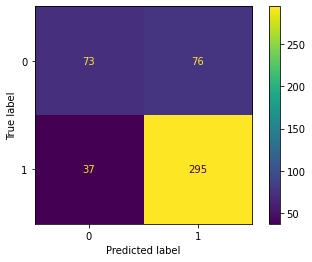

In [ ]:
print("Random forest contingency_matrix")
plot_confusion_matrix(grid_rfc, X_train2, y_train2)

In [ ]:
import pickle
    
pickle.dump(grid_rfc, open('classifier.pickle', 'wb'))

In [55]:
#call on model instance

#predictions dictionary
json_data = {'Gender': 'Male',
           'Married': 'No',
           'Dependents': 0,
           'Self_Employed': 'No',
           'LoanAmount': 500.0,
           'Loan_Amount_Term': 360.0,
           'Credit_History' : 0.0,
           'TotalIncome': 10000.0}

import requests
URL = "http://ec2-35-174-113-161.compute-1.amazonaws.com:5000/predict"
# sending get request and saving the response as response object 
r = requests.post(url = URL, json = json_data)
print(r.json())

ConnectionError: HTTPConnectionPool(host='ec2-35-174-113-161.compute-1.amazonaws.com', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x1a26c5f898>: Failed to establish a new connection: [Errno 61] Connection refused',))

### Model 3

In [ ]:
import xgboost as xgb
#data_dmatrix = xgb.DMatrix(data=X2,label=y2, enable_categorical=True,)

In [ ]:
import xgboost as XGBClassifier
#create pipeline
from sklearn.ensemble import RandomForestClassifier
x_boost = Pipeline([('preprocessing', preprocessing),
                         ('one_hot', OneHotEncoder(sparse=False)),
                         ('scaling', MinMaxScaler()),
                        ('model', xgb.XGBClassifier())])

#fit
x_boost.fit(X_train2, y_train2)

#find accruacy
y_prediction = x_boost.predict(X_test2)

# Calculate Model Accuracy
print("Accuracy:", accuracy_score(y_test2, y_prediction))

[13:37:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.8016528925619835


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Create the parameter grid
gbm_param_grid = {
    'model__learning_rate': np.arange(0.05, 1, 0.05),
    'model__max_depth': np.arange(3, 10, 1),
    'model__n_estimators': np.arange(50, 200, 50)
}

# Perform RandomizedSearchCV
randomized_roc_auc = RandomizedSearchCV(estimator=x_boost, param_distributions=gbm_param_grid,
                                        n_iter=2, scoring='roc_auc', cv=2, verbose=1)

# Fit the estimator
randomized_roc_auc.fit(X_train2, y_train2)

# Compute metrics
print('Score: ', randomized_roc_auc.best_score_)
print('Estimator: ', randomized_roc_auc.best_estimator_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[13:37:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with

In [ ]:
print('Best Params', randomized_roc_auc.best_params_)
print('Final score is: ', randomized_roc_auc.score(X_test2, y_test2))

Best Params {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.8}
Final score is:  0.7358909321496513
